In [1]:
import itertools
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_recall_curve, average_precision_score

tf.get_logger().setLevel('ERROR')

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (100, 100) 
SEED = 1337
NUM_CLASSES = 36

TRAIN_DIR = "../data/train"
TEST_DIR = "../data/test"
MODEL_PATH = "../Models/best_model.keras"

In [3]:
model = load_model("../Models/best_model.keras")

In [4]:
CLASS_MAP = {
    i: c for i, c in enumerate(
        ['0','1','2','3','4','5','6','7','8','9',
        'a','b','c','d','e','f','g','h','i','j',
        'k','l','m','n','o','p','q','r','s','t',
        'u','v','w','x','y','z']
    )
}

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    validation_split=0.2,
    subset='training',
    seed=SEED
)

Found 28800 files belonging to 36 classes.
Using 23040 files for training.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale',
    shuffle=False
)

Found 7236 files belonging to 36 classes.


In [7]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print('Classes:', class_names)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4467, Test Accuracy: 0.9060


In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(10,8))
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j]
        if normalize:
            fmt = '{:.2f}'.format(val)
        else:
            fmt = str(int(val))
        plt.text(j, i, fmt, horizontalalignment='center',
                    color='white' if val > thresh else 'black', fontsize=6)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


227/227 [==============================] - 2s 10ms/step


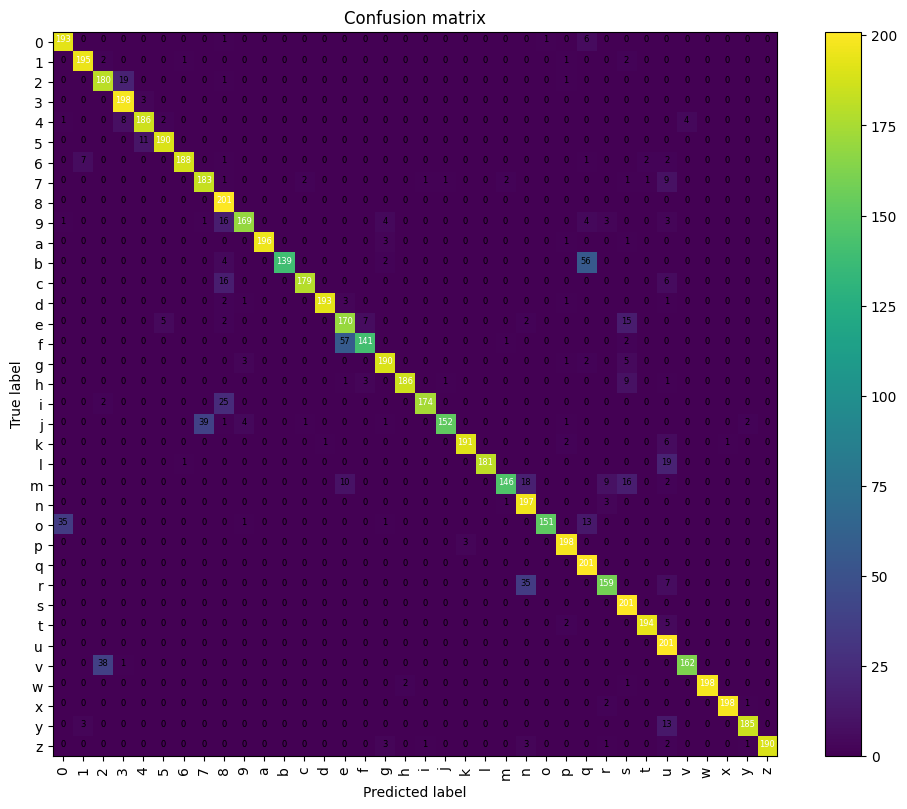

In [10]:
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, class_names, normalize=False)
plt.show()

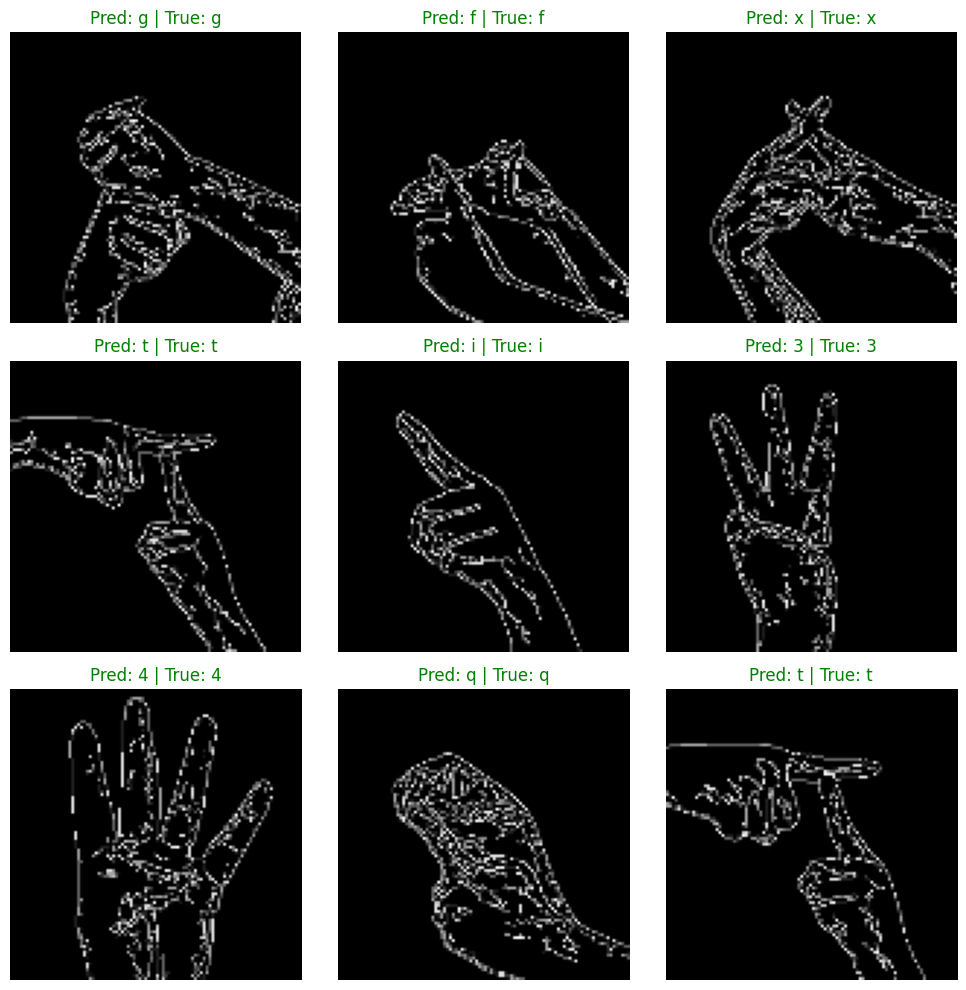

In [11]:
all_images, all_labels = [], []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

preds = model.predict(all_images, verbose=0)
preds = np.argmax(preds, axis=1)
true_labels = np.argmax(all_labels, axis=1)

indices = np.random.choice(range(len(all_images)), size=9, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[idx].squeeze(), cmap='gray')
    pred_label = preds[idx]
    true_label = true_labels[idx]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {class_names[pred_label]} | True: {class_names[true_label]}", color=color)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

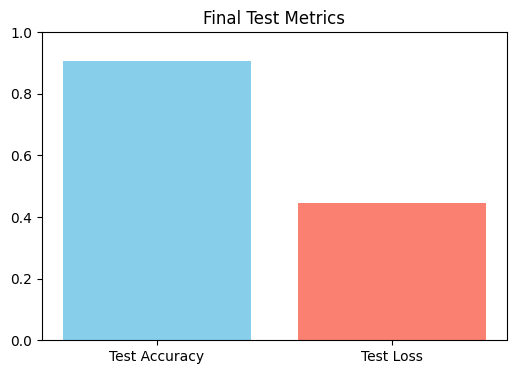

In [12]:
plt.figure(figsize=(6,4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, loss], color=['skyblue','salmon'])
plt.title("Final Test Metrics")
plt.ylim(0, max(1.0, loss + 0.1))
plt.show()

In [13]:
def predict_with_tta(model, dataset, num_augmentations=5):
    """Average predictions over multiple passes through dataset (TTA)"""
    preds = []
    for _ in range(num_augmentations):
        preds.append(model.predict(dataset, verbose=0))
    final_preds = np.mean(preds, axis=0)
    return np.argmax(final_preds, axis=1)

tta_preds = predict_with_tta(model, test_ds)

In [14]:
tta_acc = accuracy_score(y_true, tta_preds)
print(f"TTA Test Accuracy: {tta_acc:.4f}")

cm = confusion_matrix(y_true, tta_preds)

TTA Test Accuracy: 0.9060


In [15]:
print(classification_report(y_true, y_pred, target_names=list(CLASS_MAP.values())))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       201
           1       0.95      0.97      0.96       201
           2       0.81      0.90      0.85       201
           3       0.88      0.99      0.93       201
           4       0.93      0.93      0.93       201
           5       0.96      0.95      0.95       201
           6       0.99      0.94      0.96       201
           7       0.82      0.91      0.86       201
           8       0.74      1.00      0.85       201
           9       0.95      0.84      0.89       201
           a       1.00      0.98      0.99       201
           b       1.00      0.69      0.82       201
           c       0.98      0.89      0.93       201
           d       0.99      0.96      0.98       201
           e       0.71      0.85      0.77       201
           f       0.93      0.70      0.80       201
           g       0.93      0.95      0.94       201
           h       0.99    